# HCAS R notebook 01: exploratory data analysis

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 11 May 2016 (updated: 19 May 2016)

**Note**: this notebook can also be viewed at https://github.com/eric542/hcas

## Summary

This is the first notebook in a series of Jupyter R notebooks written as part of HCAS Activity 3a(1) *'Environmental Space Modelling'*. These notebooks illustrate the data processing undertaken as part of this activity, and document the development of a method to link the environmental space (ENV) with the remote sensing space (RS). The current version of HCAS (v1.0) uses a GDM approach to implement this. These notebooks were written in conjunction with the information contained in the document _'HCAS Activity 3a(1): Environmental Space Modelling -- Review / Research Document (Methods Document)'_, which provides further details regarding the implemented approach.

This first notebook is used to present some of the results obtained when carrying out exploratory data analysis (EDA) on the HCAS dataset of ENV and RS variables. The purpose of EDA generally is to provide some initial insight into the characteristics of the data, and into how this might impact the subsequent system design.

## Miscellaneous

Some preliminary `R` functions and definitions.

In [1]:
# function for plotting a colorbar in plots:
cbar = function(cmin,cmax,color_pal,ytxt="") {
    orig_mar = par("mar"); cbar_mar = c(orig_mar[1]+1,0,orig_mar[3]+1,3.7)
    par(mar=cbar_mar)
    tmp = seq(cmin,cmax,len=100)
    colsurf = matrix(c(tmp,tmp), nrow=2, byrow=TRUE)
    image(c(1,2), tmp, colsurf, col=color_pal, xlim=c(1,2), ylim=c(cmin,cmax), yaxt="n", xaxt="n", xlab="", ylab="")
    box(); axis(4); mtext(side=4, line=2.2, ytxt)
    par(mar=orig_mar)   # reset original parameters for other plots
}

In [2]:
# This allows to change the size of the figures in the notebook
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

##  Characteristics of ENV and RS variables

### Variables names and format

The various ENV and RS variables used in HCAS v1.0 (GDM fitting), as well as pairing information for the calculation of distances, were collected and provided as `.csv` files by Chris Ware from CSIRO L&W. These data were subsequently extracted into separate variables in `R` and saved to the file `HCAS_vars.Rdata`.

In [3]:
print( load("//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/HCAS_vars.Rdata") )
n_sites = dim(site_env_vars)[1]
n_pairs = dim(pind_data_NonZeroPCA)[1]

[1] "site_latlon"             "site_env_vars"          
[3] "site_GDMenv_vars"        "site_RSorig_vars"       
[5] "site_RSpca_vars"         "site_indx_NonZeroPCA"   
[7] "pind_data_NonZeroPCA"    "TH_dist_data_NonZeroPCA"


Among others, the main variables of interest are:

* `site_RSorig_vars`: N_sites-by-15 data.frame of "original" RS variables
* `site_RSpca_vars`: N_sites-by-9 data.frame of PCA'ed RS variables
* `site_env_vars`: N_sites-by-21 data.frame of "raw" ENV variables
* `site_GDMenv_vars`: N_sites-by-21 data.frame of GDM transformed ENV variables
* `pind_data_NonZeroPCA`: N_pairs-by-2 data.frame of site indices for each site pair, as used when fitting the GDM within HCAS v1.0; the label '`NonZeroPCA`' refers to an issue with the PCA'ed RS variables which was uncovered and solved during EDA (see further below); essentially, the pairing information in `pind_data_NonZeroPCA` excludes all sites affected by this issue.

The latest (clean) dataset of ENV and RS variables contains a total of 425,156 reference sites, 423,272 of which are 'valid', i.e. not affected by the above mentioned issue (1884 affected sites). Of the 999,972 pairs originally provided, 986,549 are pairs that do not contain the affected sites (13,423 affected pairs). Of the 423,272 valid sites, a total of 422,323 are used by the 'valid' pairs (949 omitted valid sites).

In [4]:
head(site_env_vars)

,elvr1000mn,geolmnagemd,gravitymn,mrvbfmn,ill20mn,kao20mn,nutrientsmd,pc1_20mn,pc2_20mn,pc3_20mn,ellip.h,soldepthmd,eaasmn,ptamn,ptimn,txxmn,wdamn,wdimn,hstructmd,pc2_80mn,pc3_80mn
1,105.8544,17.02199,556.9212,3,0.2671681,0.5508563,1,0.1470244,0.1786444,1.761004,<8b>,1.29999,829.991,1213.848,3.273668,33.28135,-314.5902,-132.4414,0,0.80208,1.106816
2,58.99224,1.294,545.9252,1.5625,0.2625669,0.5544769,1.1,1.151471,0.33015,1.713228,<8b>,0.6,908.0643,1361.517,5.750516,32.40245,-180.1044,-132.7192,0.48333,1.331989,0.8746363
3,267.9681,275,892.259,0.3125,0.2402562,0.5826969,1.1,-0.6813394,0.1204775,1.785967,<8b>,0.6,830.9374,1321.006,4.70602,32.60232,-170.349,-127.0133,0.48333,0.4819919,1.247393
4,31.28379,387.6,507.9612,1.375,0.2350543,0.5648581,1,0.4737181,0.2822156,1.661484,<8b>,1.29999,842.8867,1252.19,4.308605,32.86852,-279.8958,-132.0443,0,0.9098032,1.080981
5,299.2999,387.6,553.1973,0,0.2405856,0.5651019,1.1,0.1178212,0.3206412,1.700683,<8b>,0.6,914.996,1467.074,7.579874,31.47803,-47.47627,-126.8123,0.48333,1.208269,1.047651
6,9.610773,1.294,537.3777,6,0.2319894,0.5649932,1,1.334174,0.4090631,1.680621,<8b>,0.89999,848.6834,1266.351,4.541078,32.86556,-268.4268,-132.6823,2.38094,0.8198019,0.761585


In [5]:
head(site_RSpca_vars)

,rspc1,rspc2,rspc3,rspc4,rspc5,rspc6,rspc7,rspc8,rspc9,rspc10,rspc11,rspc12,rspc13,rspc14,rspc15
1,0.6042336,0.2011395,-0.02350637,0.4507304,0.5134932,0.08222467,0.2974522,0.4563303,0.08677078,0.1462462,0.1759794,0.02740025,0.127132,0.286945,0.0939827
2,0.6942782,0.1693865,0.07097849,0.4786293,0.6007832,0.08118036,0.290094,0.4809242,0.08271769,0.141461,0.1778298,0.03001735,0.1142302,0.2880882,0.09006099
3,1.080269,0.8089887,-0.001230362,0.3637051,0.5557375,0.04342623,0.31401,0.4318593,0.07096438,0.1514137,0.1756498,0.02793767,0.1302161,0.2874283,0.09397431
4,0.6454273,0.1396183,-0.03650967,0.4663601,0.6042628,0.09099092,0.3448189,0.4282705,0.0571179,0.1506051,0.1829931,0.01613453,0.1192096,0.2840955,0.09476513
5,0.8778304,0.3799748,0.004028289,0.4363029,0.6164365,0.05324411,0.333705,0.4534152,0.07607694,0.1412396,0.1908599,0.01979133,0.1176142,0.2884599,0.0942655
6,0.4177582,0.2356873,-0.005658563,0.5027047,0.5939689,0.1118858,0.3275697,0.4398969,0.05839691,0.138986,0.1724188,0.03013597,0.12703,0.284315,0.09338996


### ENV and RS "within-set" scatterplots

EDA scatterplots of the ENV and RS variables provide insight into the characteristics and correlations existing among variables. 

**ENV variables** -- Let's see how, e.g., the 6th ENV variable (labelled 'kao20mn') correlates with other ENV variables.

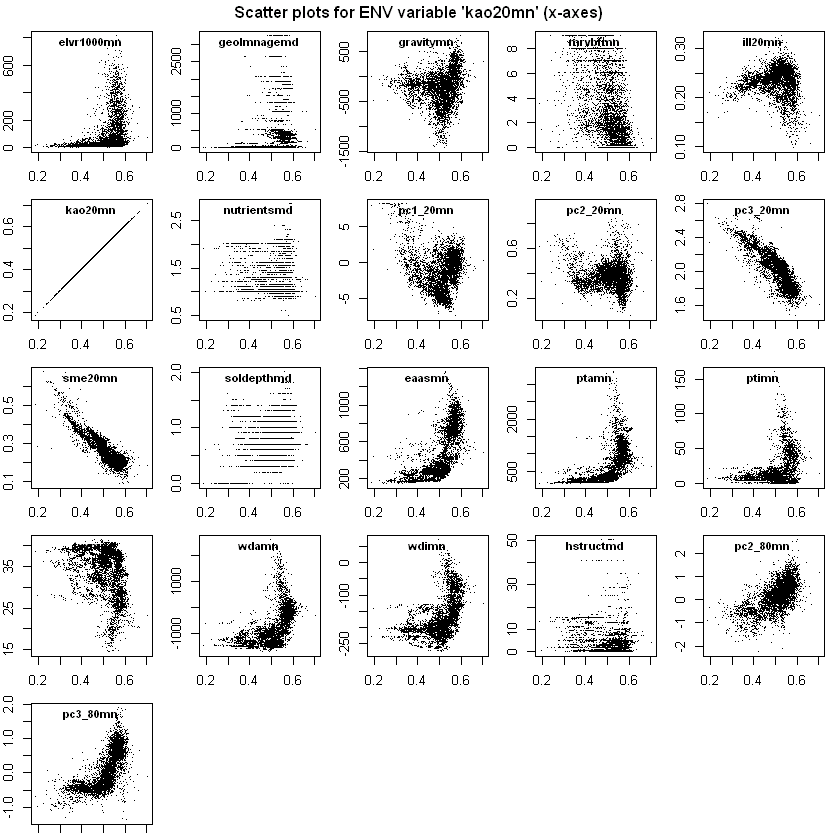

In [6]:
options(repr.plot.width=7, repr.plot.height=7)
layout( matrix(1:25,nrow=5,byrow=T) )
par(mar=c(1,2,2,1))

n_env = dim(site_env_vars)[2]
env_names = colnames(site_env_vars)
subset = site_env_vars[seq(1,n_sites,by=100),]   # use a subset to reduce nr of plotted data points
for ( nn in 1:n_env ) {
    plot(subset[,6], subset[,nn], ylab="", xlab="", main="", pch='.')
    title(env_names[nn], line=-0.9, cex.main=0.8)
}
title(paste("Scatter plots for ENV variable '",env_names[6],"' (x-axes)", sep=''), outer = TRUE, line = -1.1)

This specific example shows that the ENV variable 'kao20mn' is relatively strongly (negatively) correlated with the variables 'pc3_20mn' and 'sme20mn' (end of 2nd and start of 3rd rows). Some of these variables could thus possibly be combined and/or removed without substantially imacting on the overall system performance. HCAS v1.0 currently a process of backwards elimination to reduce the number of selected ENV variables.

This kind of analysis can be repeated for all ENV variables (predictor variables in the GDM), here saved to a `.pdf` file:

In [7]:
pdf('./HCAS_EDA_ENV_scatterplots.pdf', width=20, height=20, pointsize=20)
n_rows = ceiling(sqrt(n_env))
layout( matrix(1:n_rows^2,nrow=n_rows,byrow=T) )
par(mar=c(2,2,2,1))

for ( vv in 1:n_env ) {
    for ( nn in 1:n_env ) {
        if ( nn<vv ) { plot.new(); next }
        plot(subset[,vv], subset[,nn], ylab="", xlab="", main="", pch='.')
        title(env_names[nn], line=-1.3)
    }
    title(paste("Scatter plots for ENV variable '", env_names[vv], "' (x-axes)", sep=''), outer = TRUE, line = -1.1)
    n_skip = n_rows^2 - n_env
    if ( n_skip>0 ) for ( nn in 1:n_skip ) plot.new()
}
tmp = dev.off()

**GDM-trransformed ENV variables** -- As part of this activity, scatterplots were also generated for the GDM-transformed ENV variables `site_GDMenv_vars`. Results similar to those shown above (for the non-transformed ENV variables) were obtained, with some (few) variables exhibiting a mild degree of correlation. 

**Original RS variables** -- The following plots presents an example of EDA scatterplots for the _original_ (i.e. non-PCA'ed) RS variable 'rec_meanMax':

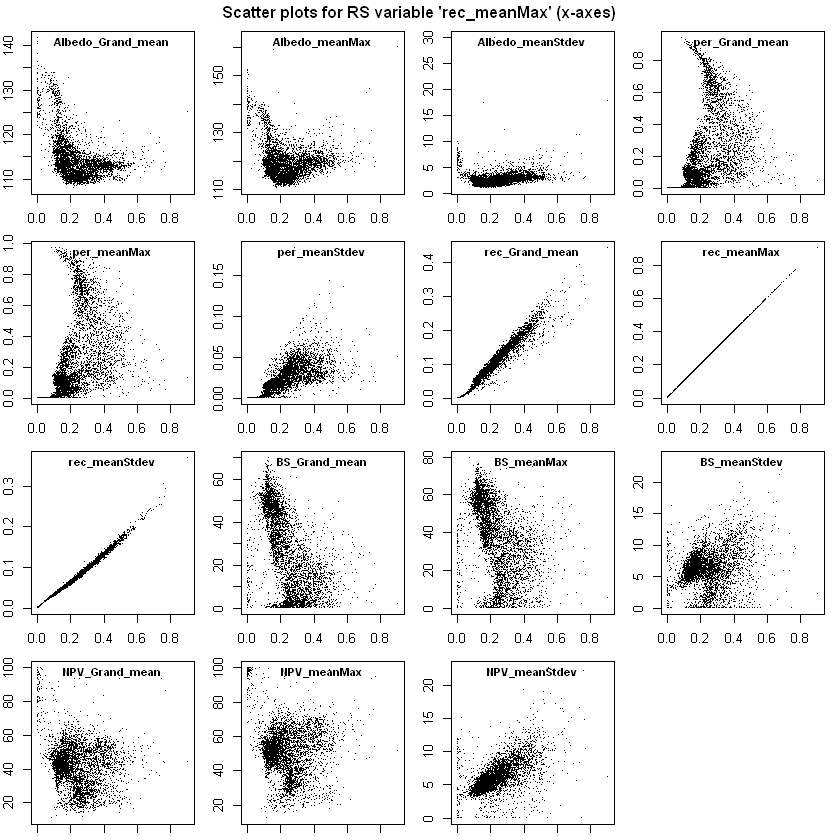

In [8]:
layout( matrix(1:16,nrow=4,byrow=T) )
par(mar=c(1,2,2,1))

n_rs = dim(site_RSorig_vars)[2]
rs_names = colnames(site_RSorig_vars)
subset = site_RSorig_vars[seq(1,n_sites,by=100),]   # use a subset to reduce nr of plotted data points
for ( nn in 1:n_rs ) {
    plot(subset[,8], subset[,nn], ylab="", xlab="", main="", pch='.')
    title(rs_names[nn], line=-0.9, cex.main=0.8)
}
title(paste("Scatter plots for RS variable '",rs_names[8],"' (x-axes)", sep=''), outer = TRUE, line = -1.1)

Here, this example shows that a strong correlation exists between the variables 'rec_meanMax', 'rec_Grand_mean' and 'rec_meanStdev'. Other strongly correlated variables include:

* 'Albedo_Grand_mean' and 'Albedo_meanMax'
* 'per_Grand_mean' and 'per_meanMax'
* 'BS_Grand_mean' and 'BS_meanMax'
* 'NPV_Grand_mean' and 'NPV_meanMax'

This level of correlation among the original RS variables corroborates the need for the subsequent PCA step to reduce the dimensionality of the RS dataset. 

Scatterplots for all the original RS variables can be saved to file as follows:

In [9]:
pdf('./HCAS_EDA_RSorig_scatterplots.pdf', width=20, height=20, pointsize=20)
n_rows = ceiling(sqrt(n_rs))
layout( matrix(1:n_rows^2,nrow=n_rows,byrow=T) )
par(mar=c(2,2,2,1))

for ( vv in 1:n_rs ) {
    for ( nn in 1:n_rs ) {
        if ( nn<vv ) { plot.new(); next }
        plot(subset[,vv], subset[,nn], ylab="", xlab="", main="", pch='.')
        title(rs_names[nn], line=-1.3)
    }
    title(paste("Scatter plots for RS variable '", rs_names[vv], "' (x-axes)", sep=''), outer = TRUE, line = -1.1)
    n_skip = n_rows^2 - n_rs
    if ( n_skip>0 ) for ( nn in 1:n_skip ) plot.new()
}
tmp = dev.off()

**PCA'ed RS variables** -- The same EDA can be carried out for the PCA'ed RS variables (response variables for the GDM):

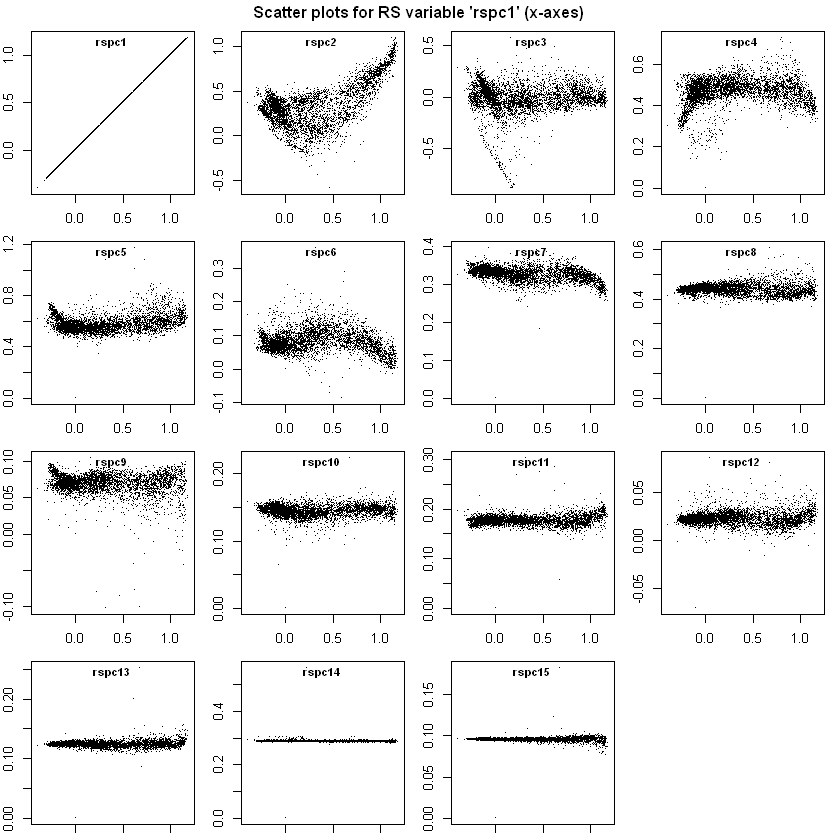

In [10]:
layout( matrix(1:16,nrow=4,byrow=T) )
par(mar=c(1,2,2,1))

n_rs = dim(site_RSpca_vars)[2]
rs_names = colnames(site_RSpca_vars)
subset = site_RSpca_vars[seq(1,n_sites,by=100),]   # use a subset to reduce nr of plotted data points
for ( nn in 1:n_rs ) {
    plot(subset[,1], subset[,nn], ylab="", xlab="", main="", pch='.')
    title(rs_names[nn], line=-0.9, cex.main=0.8)
}
title(paste("Scatter plots for RS variable '",rs_names[1],"' (x-axes)", sep=''), outer = TRUE, line = -1.1)

As expected, the PCA operation on the original RS variables has essentially removed all correlation among variables (making them orthogonal). Again, all the RS scatter plots can be saved to `.pdf` file:

In [11]:
pdf('./HCAS_EDA_RSpca_scatterplots.pdf', width=20, height=20, pointsize=20)
n_rows = ceiling(sqrt(n_rs))
layout( matrix(1:n_rows^2,nrow=n_rows,byrow=T) )
par(mar=c(2,2,2,1))

for ( vv in 1:n_rs ) {
    for ( nn in 1:n_rs ) {
        if ( nn<vv ) { plot.new(); next }
        plot(subset[,vv], subset[,nn], ylab="", xlab="", main="", pch='.')
        title(rs_names[nn], line=-1.3)
    }
    title(paste("Scatter plots for RS variable '", rs_names[vv], "' (x-axes)", sep=''), outer = TRUE, line = -1.1)
    n_skip = n_rows^2 - n_rs
    if ( n_skip>0 ) for ( nn in 1:n_skip ) plot.new()
}
tmp = dev.off()

### ENV and RS "between-set" scatterplots

An important aspect of regression modelling is to check for collinearity between the set of response and predictor variables. Although the HCAS approach is based on a different principle (where the ENV and RS variables are _both_ "predictors" for the condition metric), such exploratory analyses can still provide interesting insight into the data.

**ENV vs. PCA'ed RS variables** -- Scatterplots of the ENV variables against the PCA-processed RS variables can be generated as follows:

In [12]:
# All plots saved to file:
pdf('./HCAS_EDA_ENVvsRSpca_scatterplots.pdf', width=20, height=20, pointsize=20)
n_env = dim(site_env_vars)[2]
n_rs = dim(site_RSpca_vars)[2]
env_names = colnames(site_env_vars)
rs_names = colnames(site_RSpca_vars)

env_subset = site_env_vars[seq(1,n_sites,by=100),]
rs_subset = site_RSpca_vars[seq(1,n_sites,by=100),]

n_r = ceiling(sqrt(n_rs))
layout( matrix(1:n_r^2,nrow=n_r,byrow=T) )
par(mar=c(2,2,2,1))

for ( vv in 1:n_env ) {
    for ( nn in 1:n_rs ) {
        plot(env_subset[,vv], rs_subset[,nn], ylab="", xlab="", main="", pch='.')
        title(rs_names[nn], line=-1.3)
    }
    title(paste("Scatter plots for ENV variable '", env_names[vv], "' (x-axes)", sep=''), outer = TRUE, line = -1.1)
    n_skip = n_r^2 - n_rs
    if ( n_skip>0 ) for ( nn in 1:n_skip ) plot.new()
}
tmp = dev.off()

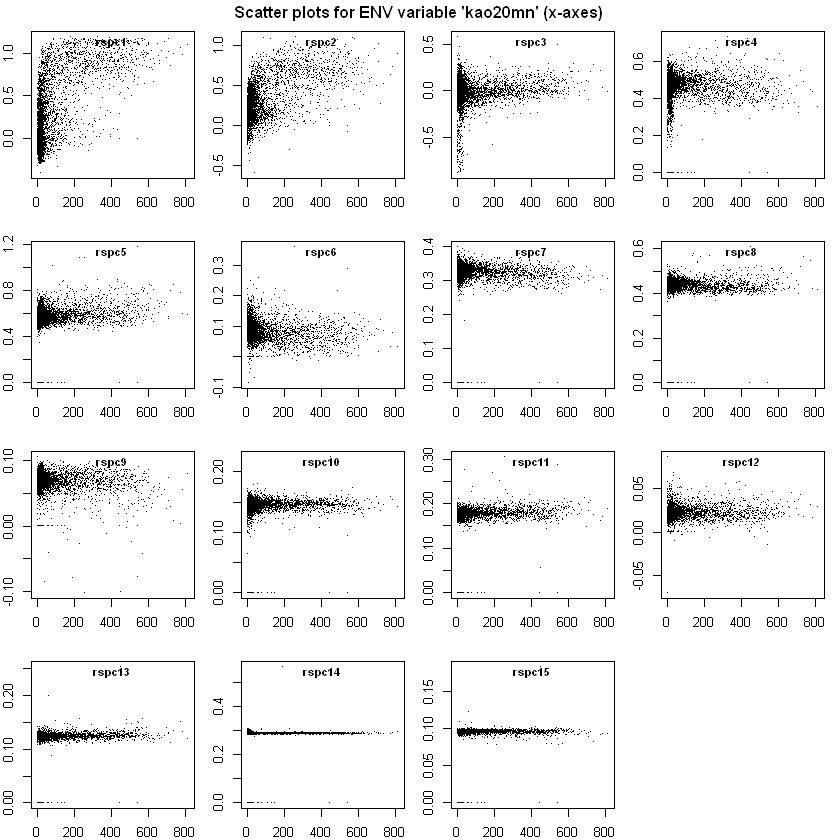

In [13]:
# Example plot:
layout( matrix(1:n_r^2,nrow=n_r,byrow=T) )
par(mar=c(2,2,2,1))

for ( nn in 1:n_rs ) {
    plot(env_subset[,1], rs_subset[,nn], ylab="", xlab="", main="", pch='.')
    title(rs_names[nn], line=-0.9, cex.main=0.8)
}
title(paste("Scatter plots for ENV variable '", env_names[6], "' (x-axes)", sep=''), outer = TRUE, line = -1.1)

These results show that very little correlation (no collinearity) exists among the RS and ENV variables used as input to the GDM. Note also the series of data points located at $y = 0$ in the above scatter plots -- we'll get back to that specific issue shortly.

**GDM-transformed ENV vs. PCA'ed RS variables** -- Now, let's see what sort of dependence exists between the GDM-transformed ENV variables and the (PCA-processed) RS variables.

In [14]:
# All plots saved to file:
pdf('./HCAS_EDA_gdmENVvsRSpca_scatterplots.pdf', width=20, height=20, pointsize=20)
n_env = dim(site_GDMenv_vars)[2]
n_rs = dim(site_RSpca_vars)[2]
env_names = colnames(site_GDMenv_vars)
rs_names = colnames(site_RSpca_vars)

env_subset = site_GDMenv_vars[seq(1,n_sites,by=100),]
rs_subset = site_RSpca_vars[seq(1,n_sites,by=100),]

n_r = ceiling(sqrt(n_rs))
layout( matrix(1:n_r^2,nrow=n_r,byrow=T) )
par(mar=c(2,2,2,1))

for ( vv in 1:n_env ) {
    for ( nn in 1:n_rs ) {
        plot(env_subset[,vv], rs_subset[,nn], ylab="", xlab="", main="", pch='.')
        title(rs_names[nn], line=-1.3)
    }
    title(paste("Scatter plots for GDM-ENV variable '", env_names[vv], "' (x-axes)", sep=''), outer = TRUE, line = -1.1)
    n_skip = n_r^2 - n_rs
    if ( n_skip>0 ) for ( nn in 1:n_skip ) plot.new()
}
tmp = dev.off()

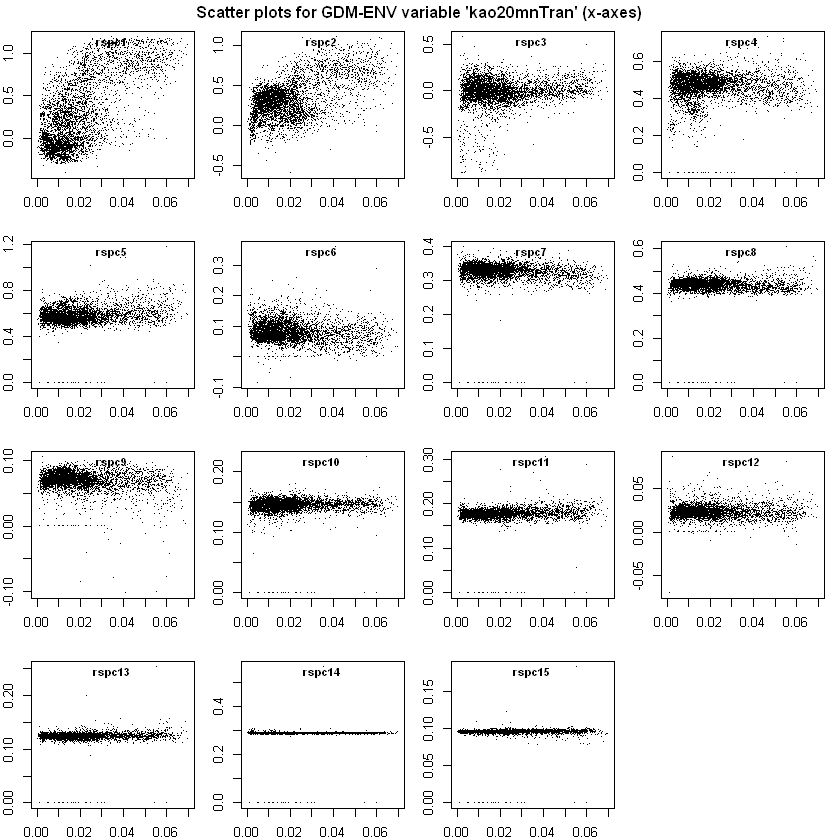

In [15]:
# Example plot:
layout( matrix(1:n_r^2,nrow=n_r,byrow=T) )
par(mar=c(2,2,2,1))

for ( nn in 1:n_rs ) {
    plot(env_subset[,1], rs_subset[,nn], ylab="", xlab="", main="", pch='.')
    title(rs_names[nn], line=-0.9, cex.main=0.8)
}
title(paste("Scatter plots for GDM-ENV variable '", env_names[6], "' (x-axes)", sep=''), outer = TRUE, line = -1.1)

The results are here very similar to the non-GDM-transformed plots above, and again show that there is little correlation between the GDM outputs (transformed ENV variables) and the RS variables. As shown below, the GDM transforms the ENV variables such that _distance_ measured in the ENV and RS spaces correlate maximally, but without providing any links between the ENV and RS variables themselves. 

Investigation of the results obtained for all variables (see above file 'HCAS_EDA_gdmENVvsRSpca_scatterplots.pdf') indicates that some (very few) variables exhibit some degree of correlation. In such cases, the dependence is not very strong, and this is far from a consistent result (where, e.g., _all_ RS variables would show a strong degree of correlation with at least one GDM-transformed ENV variable).

## ENV vs. RS distances

Using the above variables, the Manhattan distances between pairs of refecence sites (as used in HCAS v1.0) can be calculated, both in the ENV and RS spaces:

In [16]:
if (0) {   # not run...
    env_dist = rep(NA,n_pairs)
    rsm_dist = rep(NA,n_pairs)
    
    for ( pp in 1:n_pairs ) {   # selected site pair
        env1 = site_GDMenv_vars[pind_data_NonZeroPCA[pp,1],] 
        env2 = site_GDMenv_vars[pind_data_NonZeroPCA[pp,2],] 
        env_dist[pp] = sum(abs(env1-env2),na.rm=TRUE)   # ENV Manhattan distance
        
        rsm1 = site_RSpca_vars[pind_data_NonZeroPCA[pp,1],1:9] / 4
        rsm2 = site_RSpca_vars[pind_data_NonZeroPCA[pp,2],1:9] / 4
        rsm_dist[pp] = sum(abs(rsm1-rsm2),na.rm=TRUE)   # RS Manhattan distance
    }
}

Note that the RS variables are divided by a scaling factor of 4.0 as this scaling (applied within HCAS v1.0) wasn't applied to the data provided in the `.csv` files. Also, the RS Manhattan distance here only uses the first 9 PCA variables, as done in HCAS v1.0.

The code above typically takes a while to run, so instead of running the code within this notebook, the calculations were executed offline and saved to file:

In [17]:
print( load("//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/hcas_dist_GDMenv.Rdata") )
print( load("//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/hcas_dist_RSpca9.Rdata") )
#n_pairs = length(env_dist_NonZeroPCA)

[1] "env_dist_NonZeroPCA"
[1] "rsm_dist_NonZeroPCA"


(Here again, the label 'NonZeroPCA' means that the sites affected by the above mentioned PCA issue were omitted from the calculations).

We can now generate a scatterplot of the RS distance vs. ENV distance for the reference sites. As described in the above mentioned _'HCAS 3a(1) Methods Document'_, the correlation between the RS and ENV distances is what enables the system to infer the expected distance of a test site (to a number of selected "nearby" reference sites), and subsequently provide an estimate of its condition.

The next piece of code generates the scatterplot for a subset of the pairs (there are approx. 1 million pairs in total):

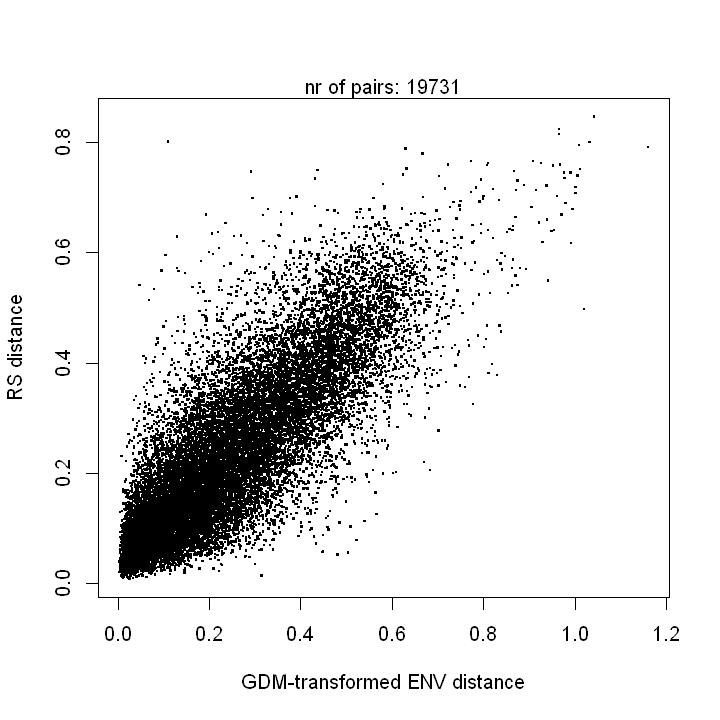

In [18]:
options(repr.plot.width=6, repr.plot.height=6)
p_indx = seq(1, n_pairs, by=50)
plot(env_dist_NonZeroPCA[p_indx], rsm_dist_NonZeroPCA[p_indx], 
     pch='.', cex=2, xlab="GDM-transformed ENV distance", ylab="RS distance")
mtext(paste("nr of pairs:",length(p_indx)))

Scatterplots become somewhat intractable with a large number of points, so we can use an alternative plotting method using a 2D histogram instead. The code below does this and also computes some statistics of interest from the data.

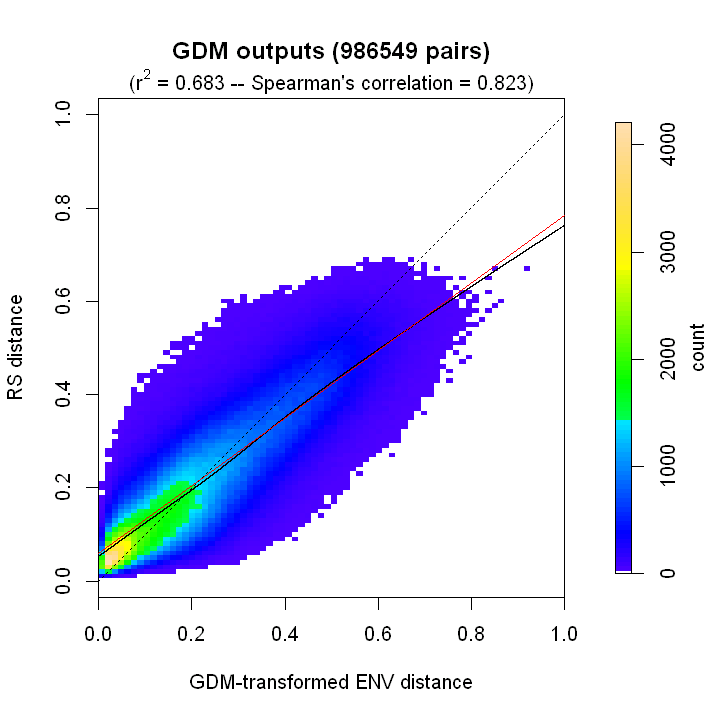

In [19]:
suppressWarnings( library(gplots, warn=FALSE) )
layout(matrix(c(1,2),nrow=1), widths=c(10,1.7))

# histogram of distances:
tmp = hist2d( env_dist_NonZeroPCA, rsm_dist_NonZeroPCA, nbins=c(100,100), 
              col=c("#FFFFFF",topo.colors(250)), ylim=c(0,1), xlim=c(0,1), asp=1 )
title( xlab="GDM-transformed ENV distance", ylab="RS distance", 
       main=paste("GDM outputs (",n_pairs," pairs)",sep='') )
box()

# LM and polynomial fits:
abline(0,1,lty=3)
lines(lowess(env_dist_NonZeroPCA, rsm_dist_NonZeroPCA), col="black")
lm_out = lm(rsm_dist_NonZeroPCA~env_dist_NonZeroPCA)
abline(lm_out, col="red")

# correlation coefficients:
r2 = round(summary(lm_out)$r.squared,3)
cc = round(cor(rsm_dist_NonZeroPCA, env_dist_NonZeroPCA, method='spearman'),3)
title( main=bquote(paste('(',r^2,' = ',.(r2)," -- Spearman's correlation = ",.(cc),')',sep='')), 
       line=0.75, font.main=1, cex.main=1 )

cbar(0, max(tmp$count,na.rm=T), color_pal=c("#FFFFFF",topo.colors(250)), 'count')

In a sense, the above figure represents a benchmark for the implementation of an alternative method to GDM. Reproducing this kind of correlation between ENV and RS distance will be the first thing to test with a new method.

GDM is an approach that essentially transforms the ENV space so that the ENV and RS distances between sites are as correlated as possible (as shown in the previous plot), but does not provide a direct link between the individual variables in RS and ENV space, as shown earlier.

## RS variables histograms

Investigations of the histograms for the RS variables also reveals some information of interest. Let's first start with the histograms of the original RS variables.

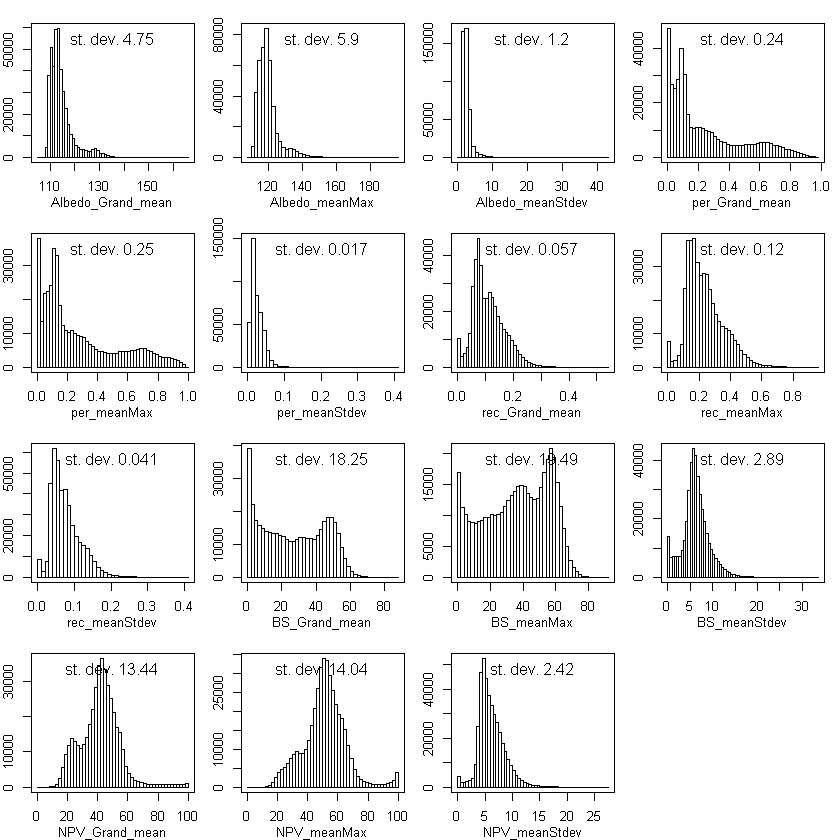

In [20]:
options(repr.plot.width=7, repr.plot.height=7)
rs_names = colnames(site_RSorig_vars)
n_r = ceiling(sqrt(n_rs))
layout( matrix(1:n_r^2,nrow=n_r,byrow=T) )
par(mar=c(3,2,1.5,1))

for ( vv in 1:n_rs ) {
    dd = site_RSorig_vars[,vv]
    hist(dd,50,main="",xlab="",ylab=""); box()
    title(xlab=rs_names[vv], line=2)
    sddd = sd(dd)
    title(paste("st. dev.",if(sddd>=1){round(sddd,2)}else{signif(sddd,2)}), line=-1.3, font.main=1)
}

The range of values taken by the RS variables varies considerably, with 'Albedo_meanMax' varying approx. from 110 to 160, and 'per_meanStdev' varying approx. from 0 to 0.1.

Let's now have a look at the same plots, once PCA has been applied to the RS data:

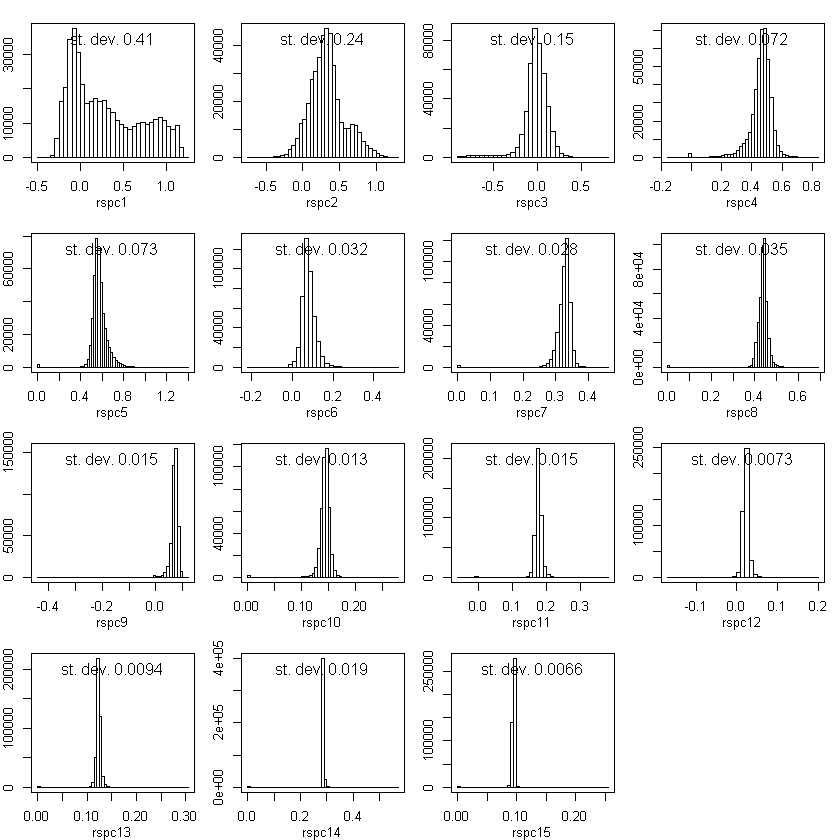

In [21]:
layout( matrix(1:n_r^2,nrow=n_r,byrow=T) )
par(mar=c(3,2,1.5,1))
rs_names = colnames(site_RSpca_vars)
for ( vv in 1:n_rs ) {
    dd = site_RSpca_vars[,vv]
    hist(dd,50,main="",xlab="",ylab=""); box()
    title(xlab=rs_names[vv], line=2)
    sddd = sd(dd)
    title(paste("st. dev.",if(sddd>=1){round(sddd,2)}else{signif(sddd,2)}), line=-1.3, font.main=1)
}

The range of values for each variables following the PCA operation have now been "unified" (normalised) among the RS variables, which are now all contained within the range from approx. -0.5 to 1. This means that the originally dominant variables will not numerically "swamp" the subsequent distance calculations (Manhattan distance). 

This plot however demonstrates how the information (variance) carried by each PCA component gradually decreases as the PCA order increases. While the first PCA has a standard deviation of 0.41, PCA nr. 15 is more or less constant at 0.1 (+/- 0.007). This means that the higher-order components have little discrimination capacity, and will thus have little influence in the Manhattan distance calculations.

E.g., defining the Manhattan distance between two $P$-dimensional variables at sites $i$ and $j$ as follows:

$$ D_\text{Manh}^{(ij)} = \sum_{p=1}^P \big|\ x_p^{(i)} - x_p^{(j)} \ \big| $$

it is clear that the summand will become increasingly negligible as $p$ increases for the PCA'ed RS variables. This issue was raised in Section 2.1 of the _'HCAS 3a(1) Methods Document'_. Note that the statistical significance of the contribution of each variable should be properly tested to support this hypothesis.

### Issue with RS PCA variables

The plot above also identifies an issue with the PCA dataset. It can be seen that many of the histograms contain some data located (seemingly suspiciously) at 0, when the bulk of the data is elsewhere (this phenomenon can also be detected in some of the above scatterplots). We can try and identify these suspicious sites and see what their PCA values are:

In [22]:
indx = which( rowSums(abs(site_RSpca_vars))==0 )
print( length(indx) )
head( site_RSpca_vars[indx,] )

[1] 1884


,rspc1,rspc2,rspc3,rspc4,rspc5,rspc6,rspc7,rspc8,rspc9,rspc10,rspc11,rspc12,rspc13,rspc14,rspc15
50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This shows that a total of 1884 rows (sites) in the PCA'ed RS variables have all PCA component equal to 0. These correspond to the data points at $y = 0$ identified in the scatter plots above. 

We can now check whether this issue originates from the original set of RS variables:

In [23]:
tmp = which( rowSums(abs(site_RSorig_vars))==0 )
length(tmp)

[1] 0

Given that none of the original RS variables are all 0, the above result (1884 sites with PCAs set to 0) is likely to haven been generated somehow during the PCA transformation of the variables. If left unchanged, this will also lead to biases when the RS data is subsequently used, e.g. when the Manhattan distances are computed.

The reason why this happening should be investigated, but the corresponding sites might be viewed as outliers for now. If we were to remove such sites, we would get "cleaner" and less biased results:

In [24]:
site_RSpca_vars = site_RSpca_vars[-indx,]

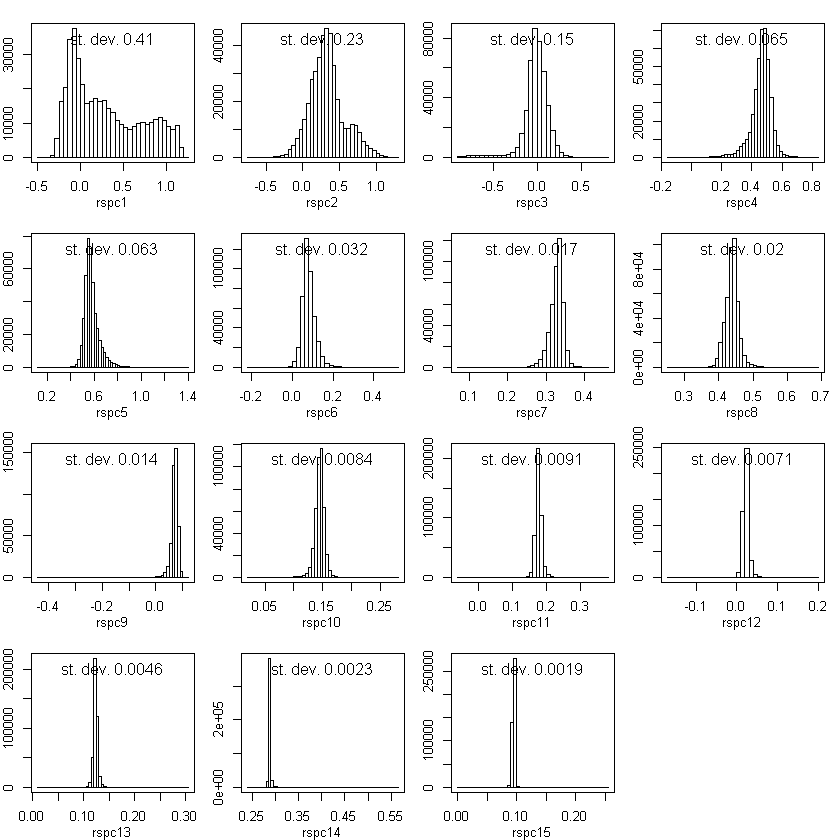

In [25]:
layout( matrix(1:n_r^2,nrow=n_r,byrow=T) )
par(mar=c(3,2,1.5,1))
rs_names = colnames(site_RSpca_vars)
for ( vv in 1:n_rs ) {
    dd = site_RSpca_vars[,vv]
    hist(dd,50,main="",xlab="",ylab=""); box()
    title(xlab=rs_names[vv], line=2)
    sddd = sd(dd)
    title(paste("st. dev.",if(sddd>=1){round(sddd,2)}else{signif(sddd,2)}), line=-1.3, font.main=1)
}